# Fast injection-recovery

Because nuance provides a way to perform the full-fledged modeling of transits in the presence of stellar variability and systematic signals, it can be used to analytically estimate the detectability of planetary signals in a given light curve.

Traditionally, this task is done empirically by injecting and blindly recovering synthetic transits. Although nothing can formerly replace this process, we can estimate the signal-to-noise ratio of an injected signal given our model of the light curve (Gaussian process + linear systematic model).

```{note}
This tutorial requires the `lightkurve` package to access the data
```

In order to run this tutorial on all available CPUs, we set the `XLA_FLAGS` env variable to

In [1]:
import os
import jax

jax.config.update("jax_enable_x64", True)
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## The dataset

We will run this tutorial on the light curve of [TOI 451](https://ui.adsabs.harvard.edu/abs/2021AJ....161...65N/abstract), for which a GP was optimized in [the previous tutorial](./GP_optimization.ipynb). Let's download the data

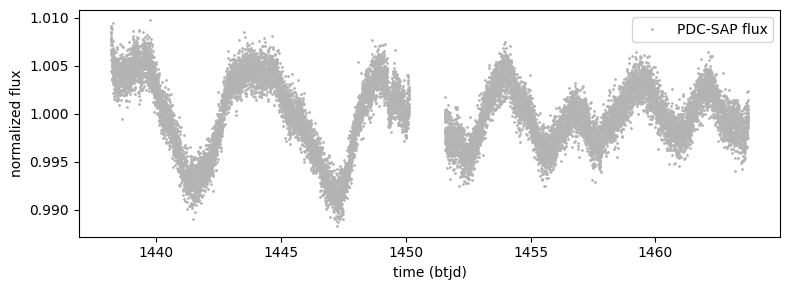

In [2]:
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np

# single sector
lc = lk.search_lightcurve("TOI 451", author="SPOC", exptime=120)[1].download()

# masking nans
time = lc.time.to_value("btjd")
flux = lc.pdcsap_flux.to_value().filled(np.nan)
error = lc.flux_err.to_value().filled(np.nan)
mask = np.isnan(flux) | np.isnan(error) | np.isnan(time)
time = time[~mask].astype(float)
flux = flux[~mask].astype(float)
error = error[~mask].astype(float)

# normalize
flux_median = np.median(flux)
flux /= flux_median
error /= flux_median

# plot
plt.figure(figsize=(8, 3))
plt.plot(time, flux, ".", c="0.7", ms=2, label="PDC-SAP flux")
plt.xlabel("time (btjd)")
plt.ylabel("normalized flux")
plt.legend()
plt.tight_layout()

and rerun the GP optimization.

In [3]:
import jax.numpy as jnp
from nuance.core import gp_model
from nuance.utils import minimize
from tinygp import kernels, GaussianProcess

# rotation period
star_period = 4.9555

# gp
initial_params = {
    "log_period": jnp.log(star_period),
    "log_Q": jnp.log(100),
    "log_sigma": jnp.log(1e-1),
    "error": np.mean(error),
}


def build_gp(params, time):

    kernel = kernels.quasisep.SHO(
        jnp.exp(params["log_sigma"]),
        jnp.exp(params["log_period"]),
        jnp.exp(params["log_Q"]),
    )

    return GaussianProcess(kernel, time, diag=params["error"] ** 2, mean=1.0)


# optimization
mu, nll = gp_model(time, flux, build_gp)
params = minimize(nll, initial_params)
gp = build_gp(params, time)

## Estimating the SNR

The analytical injection-recovery presented in this tutorial will consist in computing the recovered SNR of injected transit signals given a range of planetary radii and periods.

We will compute the duration and depths assuming a circular orbit at 0 impact parameter. Let's instantiate a [Star](nuance.Star) object to hold the stellar parameters of TOI 451

In [4]:
from nuance import core, Star

star = Star(radius=0.950, mass=0.879)

We then generate `n` random epochs and `jax.vmap` the [core.solve](nuance.core.solve) function

In [5]:
n_epochs = 10

t0s = np.random.uniform(0, 12, n_epochs)
solve_function = jax.vmap(
    jax.vmap(jax.jit(core.solve(time, flux, gp)), in_axes=(None, None, None, 0)),
    in_axes=(0, None, None, None),
)

```{note}
The [core.solve](nuance.core.solve) function returns a function that computes the depth of a transt given its epoch and duration, it has the signature `function(epoch, duration, period=None, depth=None) -> (log_likelihood, weights, variance)`. When the `depth` parameter is set, the function computes the depth of a transit **injected** with this `depth`. Usually `depth=None`, as this feature is only useful for injection-recovery estimates.
```

We can now define `snr` the function that will:
1. compute the duration of the transit given its period
2. Compute the `N` depths of the transit given a set of `N` radii
3. Compute the `n_epochs` fitted depths of the injected transits
4. Compute the SNR of the injected transits

In [6]:
@jax.jit
def snr(period, radii):
    duration = star.transit_duration(period)  # 1
    depths = star.transit_depth(radii)  # 2
    _depth, _var, _ = solve_function(t0s, duration, period, depths).T  # 3
    return _depth / jnp.sqrt(_var)  # 4

Let's compute the SNRs for a set of periods and radii

In [7]:
from tqdm import tqdm

# We downsample the period grid to speed up the calculation here
periods = star.period_grid(np.ptp(time), oversampling=0.1)
radii = np.linspace(0.5, 10.0, 50)

snrs = np.array([snr(period, radii) for period in tqdm(periods)])

100%|██████████| 83/83 [00:11<00:00,  7.00it/s]


We can now plot the resulting recovery assuming a lower limit on the SNR for a signal to be detected

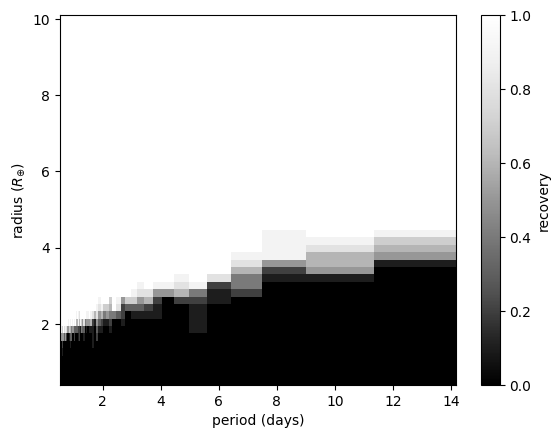

In [10]:
snr_limit = 6

ax = plt.subplot(111, xlabel="period (days)", ylabel="radius ($R_{\oplus}$)")
plt.pcolor(periods, radii, np.mean(snrs.T > snr_limit, 0), cmap="Greys_r")
_ = plt.colorbar(label="recovery")

This is a good way to see what can be detected with this optimized GP model.